In [1]:
GPU_DEVICE = -1#Please set the GPU device you want to use to execute this notebook -1 means CPU

# Adversarial images
In this notebook I ll use the discriminator trained in the notebook GAN to create adversarial images. For this purpose i will take a image from the MNIST dataset. Pass it formward trough to the descriminator, backpropagate the error for another class and see what happens.

In [10]:
import math
import json
import numpy as np
import chainer, os, collections, six, math, random, time, copy,sys
from chainer import cuda, Variable, optimizers, serializers, function, optimizer, initializers
from chainer.utils import type_check
from chainer import functions as F
from chainer import links as L
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## GAN
We will import the scripts directly for the purpose of the readability of this notebook

In [76]:
repo_root = os.path.join(os.path.split(os.getcwd())[0],'improved-gan')
mnist_root = os.path.join(repo_root,'train_mnist')
# Overwrite system arguments such that argparse in train_mnist/args.py works correctly
sys.argv = ['main','-g',str(GPU_DEVICE),'-m',os.path.join(mnist_root,'mnist'),'-p',os.path.join(mnist_root,'mnist_plot')]
# add the imported repository to the path both the general code and the train_mnist specific code
sys.path.append(repo_root)
sys.path.append(os.path.join(repo_root,'train_mnist'))

from gan import *
from params import *
# This will load the gan and the parameters learned during training
from model import gan
import mnist_tools

#load mnist images:
images,labels = mnist_tools.load_test_images()
images = images.astype(np.float32)

loading images ... (10000 / 10000)


1.0
10.0
25.0
50.0
100.0
1000.0


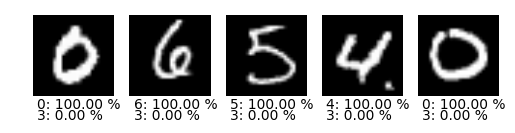

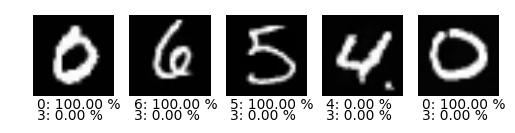

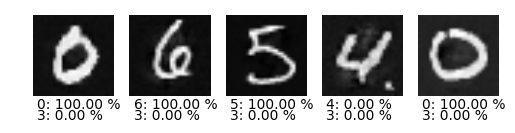

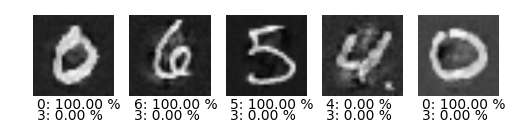

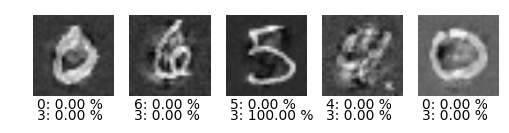

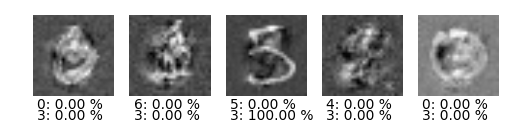

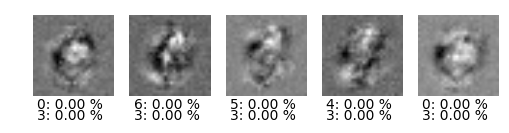

In [126]:
def _build_label(probs, label):
    """ Helper function to build label for under the image, shows the certainty 
    with which the image is classified as a certain integer
    """
    return "%d: %.2f %%" % (label, probs[label]*100.0)

def _plot_image(i,ax, correct_text, adv_text):
    """ Plots a gray scale image with some text under it
    correct_text is meant to show probability of the original correct class
    adv_text shows text that shows the advertarial image probability
    """
    i = i.reshape(28,28)
    ax.imshow(i,cmap='gray')
    ax.axis('off')
    ax.annotate(correct_text, xy=(0, 0), xytext=(1, 32))
    ax.annotate(adv_text, xy=(0, 0), xytext=(1, 36))

def plot_images(ni,imgs,probs,correct_labels,adv_labels):
    """ Plots multiple images with the probablity of the correct class and the probablity of the target adv class
    """
    fig, axarr = plt.subplots(ncols=ni)
    for i in range(ni):
        correct_label = correct_labels[i]
        adv_label = adv_labels[i]
        p = probs[i,:]
        _plot_image(imgs[i,:],axarr[i],_build_label(p, correct_label),_build_label(p, adv_label) )
    
def pass_forward(ims, gradient_classes=None):
    """ Given N images and N adv classes(class that you want the n-th image to classify wrongly as) will 
    return the gradient on the input that represent the noise that should be added to the n-th image the 
    lets it classify as the n-th adv_classes class
    """
    ims = gan.to_variable(ims) # converting to chainer variable makes sure we can obtain gradient
    probs, activations = gan.discriminate(ims,apply_softmax=False) #Now pass forward trough the network and get probs

    gradients = None
    if gradient_classes is not None:
        # our cross entropy function that will calculate the loss also need chainer var
        labels = gan.to_variable(gradient_classes) 
        loss = F.softmax_cross_entropy(probs, labels)
        #Backward pass loss
        loss.backward()
        
        #Get gradients
        gradients = ims.grad
        
    return gan.to_numpy(F.softmax(probs)), gradients

def create_adv_images(ims, gradient, factor):
    return ims - np.multiply(factor,gradient)
    

# I will calculate the gradient on the following images. These images are not picked by random.. 
#I picked different integers that classfied correctly
indexes = [3,123,15,6547,3242]
ni = len(indexes)
imgs = np.take(images,indexes,axis=0)
correct_labels = np.take(labels, indexes).astype(np.int32)
adv_labels = np.array([3 for _ in range(ni)], dtype=np.int32)


probs,grads = pass_forward(imgs,adv_labels)
plot_images(ni, imgs, probs, correct_labels, adv_labels)
for f in [1., 10.,25.,50.,100.,1000.]:
    print f
    adv_imgs = create_adv_images(imgs, grads, f)
    probs,_ = pass_forward(adv_imgs)
    plot_images(ni, adv_imgs, probs, correct_labels, adv_labels)